# Linearly fitting points
In this notebook we will take buoy points
and infer whih walls they belong to.

In [1]:
import numpy as np, matplotlib.pyplot as plt
from itertools import chain, combinations

In [2]:
# ground truth data
walls = np.load('walls.npy')
print(walls)

# given data
points = np.vstack(walls)
print(points)

# pose of AUV
pose = np.array([-15, -15, 0])

[[[ -5.06808815 -13.20282101   0.        ]
  [ -7.77966577  -7.11251796   0.        ]
  [-10.49124339  -1.02221491   0.        ]
  [-13.20282101   5.06808815   0.        ]]

 [[  1.02221491 -10.49124339   0.        ]
  [ -1.68936272  -4.40094034   0.        ]
  [ -4.40094034   1.68936272   0.        ]
  [ -7.11251796   7.77966577   0.        ]]

 [[  7.11251796  -7.77966577   0.        ]
  [  4.40094034  -1.68936272   0.        ]
  [  1.68936272   4.40094034   0.        ]
  [ -1.02221491  10.49124339   0.        ]]

 [[ 13.20282101  -5.06808815   0.        ]
  [ 10.49124339   1.02221491   0.        ]
  [  7.77966577   7.11251796   0.        ]
  [  5.06808815  13.20282101   0.        ]]]
[[ -5.06808815 -13.20282101   0.        ]
 [ -7.77966577  -7.11251796   0.        ]
 [-10.49124339  -1.02221491   0.        ]
 [-13.20282101   5.06808815   0.        ]
 [  1.02221491 -10.49124339   0.        ]
 [ -1.68936272  -4.40094034   0.        ]
 [ -4.40094034   1.68936272   0.        ]
 [ -7.1125

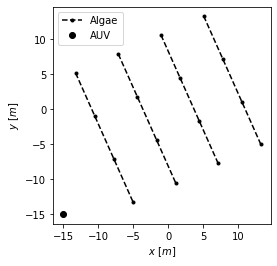

In [3]:
# make a plotter
def plot(walls, pose=None):

    # make figure and axis
    fig, ax = plt.subplots(1)

    # plot walls
    for i, wall in enumerate(walls):
        label = 'Algae' if i == 0 else None
        ax.plot(wall[:,0], wall[:,1], 'k.--', label=label)

    # plot pose if given
    if pose is not None:
        ax.plot(pose[0], pose[1], 'ko', label='AUV')

    # formatting and return
    ax.set_aspect('equal')
    ax.set_xlabel('$x~[m]$')
    ax.set_ylabel('$y~[m]$')
    ax.legend()
    return ax

ax = plot(walls, pose)
plt.show()

In [17]:
# let's compute the orientation of the farm
def orientation(walls):

    # orientations
    ors = list()

    # loop through walls
    for wall in walls:

        # get angle of wall
        theta = wall[-1,:] - wall[0,:]
        theta /= np.linalg.norm(theta)
        print(theta)
        theta = np.arctan2(theta[1], theta[0])
        theta = np.rad2deg(theta)
        ors.append(theta)

    # result
    return np.array(ors)


farm_angle = orientation(walls)
n_walls = len(farm_angle)
print('The farm has the orientations per wall: {}'.format(farm_angle))
farm_angle = farm_angle.mean()
print(farm_angle)

[-0.40673664  0.91354546  0.        ]
[-0.40673664  0.91354546  0.        ]
[-0.40673664  0.91354546  0.        ]
[-0.40673664  0.91354546  0.        ]
The farm has the orientations per wall: [114. 114. 114. 114.]
114.00000000000001


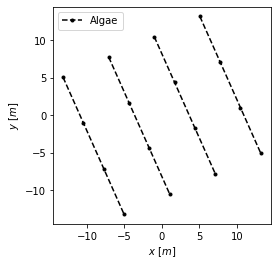

In [58]:
# Great! That seemed to work. 
# Now we will infer the walls,
# assuming that walls are maximal
# subsets.

# let's state the function we want
def line(points, theta, n_walls=4, etol=1e-4):

    # find an infimum
    ref_point = [np.linalg.norm(points - points[i], axis=1).max()
        for i in range(points.shape[0])]
    ref_point = points[np.argmax(ref_point)]

    # direction of heading
    theta = np.deg2rad(theta)
    vtheta = np.array([np.cos(theta), np.sin(theta)])

    # all binary subsets of points
    w = np.array([s for s in combinations(points, 2)])

    # Euclidian distance between each subset
    d = w[:,1,:] - w[:,0,:]
    d = np.linalg.norm(d, axis=1)

    # subsets totally ordered
    w = w[np.argsort(d)]

    # maximal walls
    mw = list()

    # loop through subsets in decreasing span-size order
    for s in reversed(w):

        # # direction of line
        vline = s[-1,:2] - s[0,:2]
        vline /= np.linalg.norm(vline)

        # loss
        l = 1.0 - abs(vline.dot(vtheta))

        # if the line fits
        if l < etol:

            # distance from points to line
            d0 = s[-1,:2] - s[0,:2]
            d1 = s[0,:2] - points[:,:2]
            d2 = np.cross(d0, d1)
            d3 = np.linalg.norm(d0)
            d = abs(d2)/d3
            
            # buoys on the wall
            b = points[d < etol]

            # sort the buoys
            b = b[np.argsort(np.linalg.norm(b - ref_point, axis=1))]

            # record the wall
            mw.append(b)

        # if we found them all
        if len(mw) == n_walls:
            break

    # sort the lines
    i = np.array([np.linalg.norm(line[0] - ref_point) for line in mw])
    mw = [mw[j] for j in np.argsort(i)]

    # array of walls
    return mw

infered_walls = line(
    points,
    farm_angle,
    n_walls=4, 
    etol=1e-6
)
ax = plot(infered_walls)
plt.show()


